<a href="https://colab.research.google.com/github/ylkim1947/Section6---Car-damage-detection/blob/main/Adding%20noise%20for%20image%20preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image preprocessing 
 When taking picture under the dim light environment, an object of the picture seems not clear. Although human vision can discriminate the object in the picture well , the AI (machine learning or deep learning) often fails to detect the objects. 

#### **That's why**

 1) The normal data from good conditions are used for training data sets of the most AI 

 2) 



### **The purpose of this script :** To preprocess the images for the deep learning models


 #### 1) For test set

* gaussian noise images

    * assuming bad condition 


 #### 2) For training set

* color Normalized images
* grey scale iamges 






#### [Reference]

https://debuggercafe.com/adding-noise-to-image-data-for-deep-learning-data-augmentation/

https://wikidocs.net/156985  : PyTorch 딥러닝 챗봇, 5-1 Transform



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

from glob import glob
dataset_path ='/content/drive/MyDrive/Colab Notebooks/project4/yolov5/Socar_Hackerthon-2'
testset_path = dataset_path +'/test/images'
img_list = glob(testset_path +'/*.jpg')

print(len(img_list))

136


# 1. Making Gaussian noise data

In [4]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image
from skimage.util import random_noise

import os
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import image

In [5]:
class TorchvisionMaskDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
       # self.imgs = list(sorted(os.listdir(self.path)))
        self.imgs = glob(self.path)
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)
        image = Image.open(img_path)
        if self.transform:
            img = self.transform(image)

        return img

torchvision_transform = transforms.Compose([
    #transforms.Resize((300, 300)), 
    #transforms.RandomCrop(224),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomHorizontalFlip(p = 1),
    transforms.ToTensor(),
])

torchvision_dataset = TorchvisionMaskDataset(
    path =testset_path +'/*.jpg',
    transform = torchvision_transform
)

In [6]:
len(torchvision_dataset) # Data 갯수

136

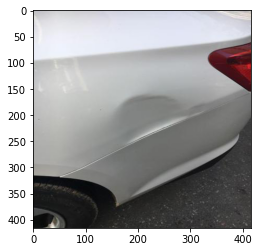

In [7]:
# Original 이미지 
img_o = image.imread(img_list[2])
plt.imshow(img_o)

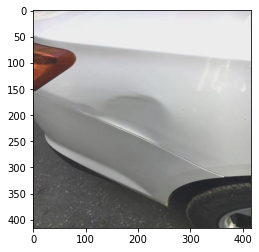

In [8]:
## Torchvison transform 한 이미지

tf = transforms.ToPILImage()
img_t = tf(torchvision_dataset[2])
plt.imshow(img_t)

In [9]:
BATCH_SIZE = 1

testloader = torch.utils.data.DataLoader(
    torchvision_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [10]:
len(testloader)

136

In [68]:
## Adding Noise step

def makedirs(path): 
    ''' 
    경로에 폴더가 없으면, 폴더 만듬 + 상위 폴더도 같이 만들어줌
    '''
    try:
      if os.path.exists(path) == False:
          os.makedirs(path)
      else: 
        print('directory already exists ')
    except OSError:
        print("Error: Failed to create the directory.")


def save_noisy_image(img, name):
    ''' 
    과정: 이미지 사이즈 변경 or 유지 --> 저장
    실행: Color value 3개 or 1개 확인

    '''  
    if img.size(0) == 3:
        img = img.view( 3, 416, 416)  # RGB 
        save_image(img, name)
    else:
        img = img.view(1, 416, 416)  # either greyscale(?) or the one of RGB
        save_image(img, name)


def Adding_noise(noise='gaussian'):
  '''
  과정: noise 생성 --> 사이즈 변경 or 유지 --> 폴더 and file 이름 변경 --> 저장
  실행: 파일이 있으면 pass 
  noise 변수: 'gaussian' , 's&p','speckle' ,‘localvar’,‘poisson’ ,‘salt’ ,'pepper 
  필요라이브러리: torch, random_noise, os 
  필요함수: save_noisy_image,makedirs
  '''
  noise_name = noise
  gau_path = f"{dataset_path}/test/images_{noise_name}/"
  makedirs(gau_path) 
  for num, data in enumerate(testloader):
        file_name =  f"{gau_path}/{num}_{noise_name}.jpg"
        if os.path.isfile(file_name) == False:
            print(f"\r processing image number: {num}",end="") 
            img = data[0]
            img = torch.tensor(random_noise(img, mode=noise_name, mean=0, var=0.05, clip=False)) # random noise filtering 
            save_noisy_image(img,file_name)
        else:
          print(f"\r passing image number: {num}",end="") 
          continue

        #break

In [69]:
Adding_noise()

directory already exists 
 processing image number: 135

In [27]:
print(img_t)

<PIL.Image.Image image mode=RGB size=416x416 at 0x7FB6A4088150>


In [52]:
for num, data in enumerate(testloader):
    print(data.shape)
    print(data.dim())
    break


torch.Size([1, 3, 416, 416])
4


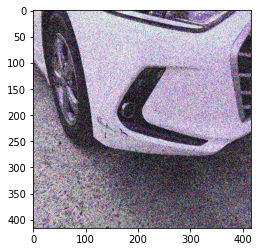

In [71]:
img_list_gaus = glob( f"{dataset_path}/test/images_gaussian/" +'/*.jpg')
# Original 이미지 
img_g = image.imread(img_list_gaus[1])
plt.imshow(img_g)

# 2. Normalization data